# Notebook 4 – VaR and CVaR from Monte Carlo


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.unified_model import get_structural_betas
from src.monte_carlo import simulate_private_paths


## Synthetic factor history (replace with real factors_real for production)

In [2]:
idx = pd.date_range('2005-01-31', periods=180, freq='M')
rng = np.random.default_rng(321)
SC = pd.Series(rng.normal(0.008, 0.05, size=len(idx)), index=idx, name='SC')
CS = pd.Series(rng.normal(0.000, 0.02, size=len(idx)), index=idx, name='CS')
INNOV = pd.Series(rng.normal(0.004, 0.04, size=len(idx)), index=idx, name='INNOV')
TAIL = pd.Series(rng.normal(0.001, 0.03, size=len(idx)), index=idx, name='TAIL')
factors_hist = pd.concat([SC, CS, INNOV, TAIL], axis=1)


/var/folders/55/623vgtzj3hn7ffs5kj635y1c0000gn/T/ipykernel_91827/2650815318.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range('2005-01-31', periods=180, freq='M')


## Simulate Buyout and VC


In [3]:
betas_bo = get_structural_betas('buyout')
betas_vc = get_structural_betas('vc')

paths_bo = simulate_private_paths(factors_hist, betas_bo, eps_sigma=0.02, n_paths=10000)
paths_vc = simulate_private_paths(factors_hist, betas_vc, eps_sigma=0.03, n_paths=10000)

# Cumulative returns over full horizon
cum_bo = (1 + paths_bo).prod(axis=1) - 1
cum_vc = (1 + paths_vc).prod(axis=1) - 1
cum_bo.describe(), cum_vc.describe()

(count    10000.000000
 mean         3.321836
 std          6.962960
 min         -0.973512
 25%          0.128970
 50%          1.368365
 75%          3.999823
 max        207.397406
 dtype: float64,
 count    10000.000000
 mean         4.036116
 std          9.295940
 min         -0.978695
 25%          0.061478
 50%          1.418585
 75%          4.546571
 max        299.895195
 dtype: float64)

## Compute VaR and CVaR


In [4]:
def var_cvar(returns: pd.Series, alpha: float = 0.05):
    q = returns.quantile(alpha)
    cvar = returns[returns <= q].mean()
    return q, cvar

for name, series in [('Buyout', cum_bo), ('VC', cum_vc)]:
    for a in [0.10, 0.05, 0.01]:
        v, c = var_cvar(series, a)
        print(f"{name} alpha={a}: VaR={v:.2%}, CVaR={c:.2%}")

Buyout alpha=0.1: VaR=-41.91%, CVaR=-61.59%
Buyout alpha=0.05: VaR=-59.68%, CVaR=-72.39%
Buyout alpha=0.01: VaR=-79.90%, CVaR=-86.32%
VC alpha=0.1: VaR=-49.08%, CVaR=-68.42%
VC alpha=0.05: VaR=-67.93%, CVaR=-78.79%
VC alpha=0.01: VaR=-85.84%, CVaR=-90.44%


## Plot distributions


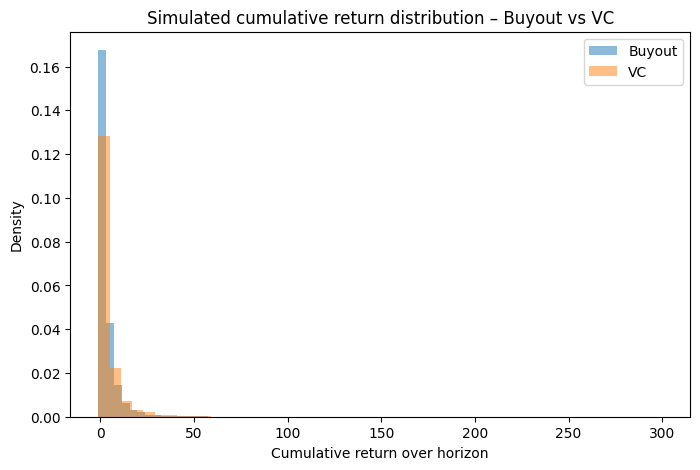

In [5]:
plt.figure(figsize=(8,5))
plt.hist(cum_bo, bins=50, alpha=0.5, density=True, label='Buyout')
plt.hist(cum_vc, bins=50, alpha=0.5, density=True, label='VC')
plt.xlabel('Cumulative return over horizon')
plt.ylabel('Density')
plt.legend()
plt.title('Simulated cumulative return distribution – Buyout vs VC')
plt.show()